In [125]:
import sys
sys.path.append(r"d:\Università\terzo anno\Tesi\astrocook")
from astrocook.functions import lines_voigt, convolve_simple
from astrocook import vars
from astropy.table import Table
import numpy as np
import scipy.signal as sps
from scipy.interpolate import interp1d
from tqdm import tqdm


In [126]:
import matplotlib.pyplot as plt

In [127]:
def bin_to_z(bin, z_start, dz):
    return z_start + bin * dz

In [128]:
def psf_gauss(x, resol):
        if len(x)==0:
            return []
        c = x[len(x)//2]
        sigma = c / resol * 4.246609001e-1

        psf = np.exp(-0.5*((x-c) / sigma)**2)
        psf = psf[np.where(psf > 1e-6)]
        return psf

In [148]:
spectrum_file = r'D:\Università\terzo anno\Tesi\AC_Correlator\test_124_200_spec.dat'
resol = 45000
logN = 12
b = 5
ion = 'CIV'
dz = 1e-5
perc = 75

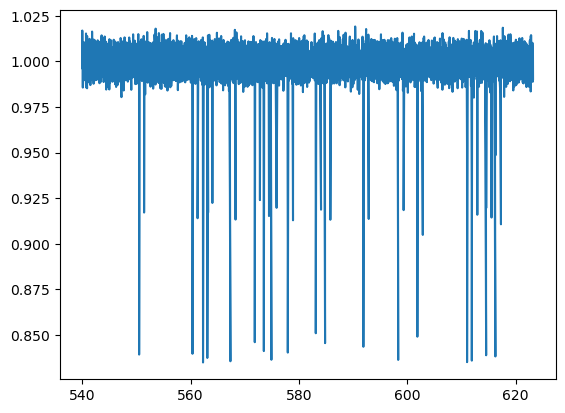

In [149]:
# Main function
# Load spectrum
spectrum = Table.read(spectrum_file, format='ascii')['x', 'y']

plt.plot(spectrum['x'], spectrum['y'])

In [150]:

# Define the region of interest
ion_components = {key: value for key, value in vars.xem_d.items() if ion in key}
c1, c2 = (float(ion_components[key].value) for key in list(ion_components)[:2])

In [151]:
# defining complete model
x = np.linspace(c1 - 4*1.665*b*c1/3e5, c2 + 4*1.665*b*c2/3e5, 1000)
y = convolve_simple(lines_voigt(x, 0, logN, b, 0, ion), psf_gauss(x, resol))
models = [Table([x, y], names=['x', 'y'])]

for c in [c1, c2]:
    x = np.linspace(c - 4*1.665*b*c/3e5, c + 4*1.665*b*c/3e5, 1000)
    y = convolve_simple(lines_voigt(x, 0, logN, b, 0, ion), psf_gauss(x, resol))
    models.append(Table([x, y], names=['x', 'y']))

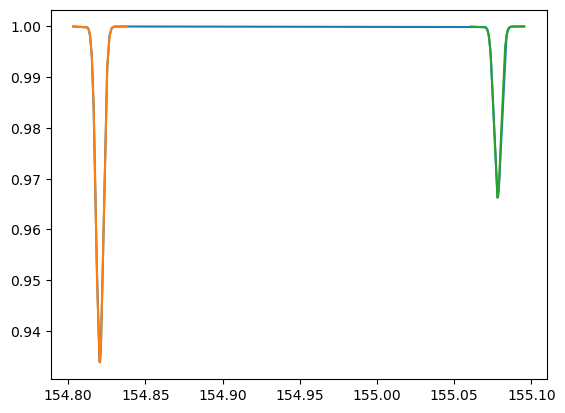

In [152]:
for model in models:
    plt.plot(model['x'], model['y'])    

In [153]:
z_start = spectrum['x'][0] / c1 - 1
z_end = spectrum['x'][-1] / c2 - 1


In [154]:

cor_all = [np.array([]),np.array([]),np.array([])]
for i,model in enumerate(models):
    for z in tqdm(np.arange(z_start, z_end, dz), f"Calculating Correlation with model {i}"):
        # Defining the interval on the spectrum in which the model is present
        mask = (spectrum['x'] > (model['x'].min())*(1+z)) & (spectrum['x'] <  (model['x'].max())*(1+z))
        spec_chunk = spectrum[mask]

        # Interpolating the model to the data wavelength
        interpolate = interp1d(model['x'], model['y'], kind='linear')
        interpolated_flux = interpolate(spec_chunk['x'] / (1+z))

        cor = np.correlate(1-interpolated_flux, 1-spec_chunk['y'], mode='valid') / len(interpolated_flux)
        cor_all[i] = np.append(cor_all[i], cor)


Calculating Correlation with model 2: 100%|██████████| 53068/53068 [00:16<00:00, 3280.35it/s]


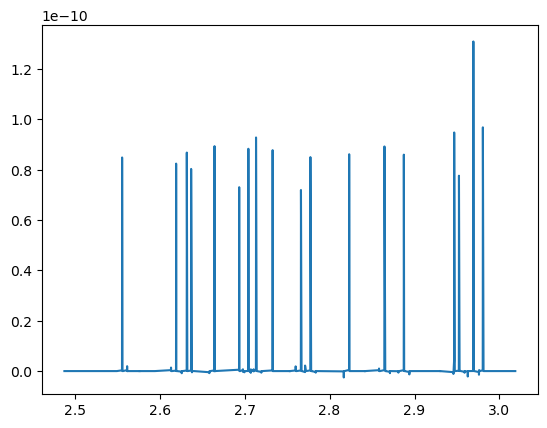

In [155]:
cor_final = (cor_all[0]) * (cor_all[1]) * (cor_all[2])

plt.plot(np.arange(z_start, z_end, dz), cor_final)


In [161]:
peaks , _ = sps.find_peaks(cor_final, height = np.mean(cor_final) + np.std(cor_final) * 2.5, prominence=0, width=0.01, distance=5e-4 / dz)

peaks = bin_to_z(peaks, z_start, dz)

In [162]:
def RPF1(peaks, synthetic_systems, b):
    tp = sum(1 for system in peaks if any(abs(system - syn)/(1+syn) < 1.665*b/3e5 for syn in synthetic_systems))
    
    fp = len(peaks) - tp
    p = len(synthetic_systems)

    recall = tp / p * 100
    precision = tp / (tp+fp) * 100
    f1 = 2 * tp / (tp + fp + p) * 100

    not_identified = [system for system in synthetic_systems if not any(abs(system - syn)/(1+syn) < 1.665*b/3e5 for syn in peaks)]

    print('Recall:', recall, '%')
    print('Precision:', precision, '%')
    print('F1 score:', f1, '%')
    print('Not identified:', not_identified)

In [163]:
synthetic_systems = [2.66462998, 2.55587099, 2.96921979, 2.76635491, 2.7774652,  2.70447149, 2.96940649, 2.73301883, 2.8231059,  2.70423362, 2.61945458, 2.9466871, 2.95230607, 2.71348916, 2.98043051, 2.63200771, 2.63711607, 2.69366724, 2.86461042, 2.88744127]

RPF1(peaks, synthetic_systems, b)


Recall: 90.0 %
Precision: 100.0 %
F1 score: 94.73684210526315 %
Not identified: [2.96940649, 2.70423362]


In [164]:
def plot_correlation(cor_final, z_interval, possible_systems, synthetic_systems):
    plt.figure(figsize=(20, 12))
    plt.plot(z_interval, cor_final)
    for system in synthetic_systems:
        plt.axvline(x=system, color='r', alpha=0.3)

    plt.axhline(np.std(cor_final) * 3 + np.mean(cor_final), color='yellow', linestyle='--', alpha=0.5)

    for system in possible_systems:
        plt.axvline(x=system, color='g', linestyle='--', alpha=0.5)

    plt.xlabel('Redshift (z)')
    plt.ylabel('Correlation')
    plt.title('Correlation vs Redshift')
    plt.legend(['Correlation', 'Mean', r'3$\sigma$', r'2$\sigma$', 'possible Systems', 'synthetic Systems'])
    plt.show()

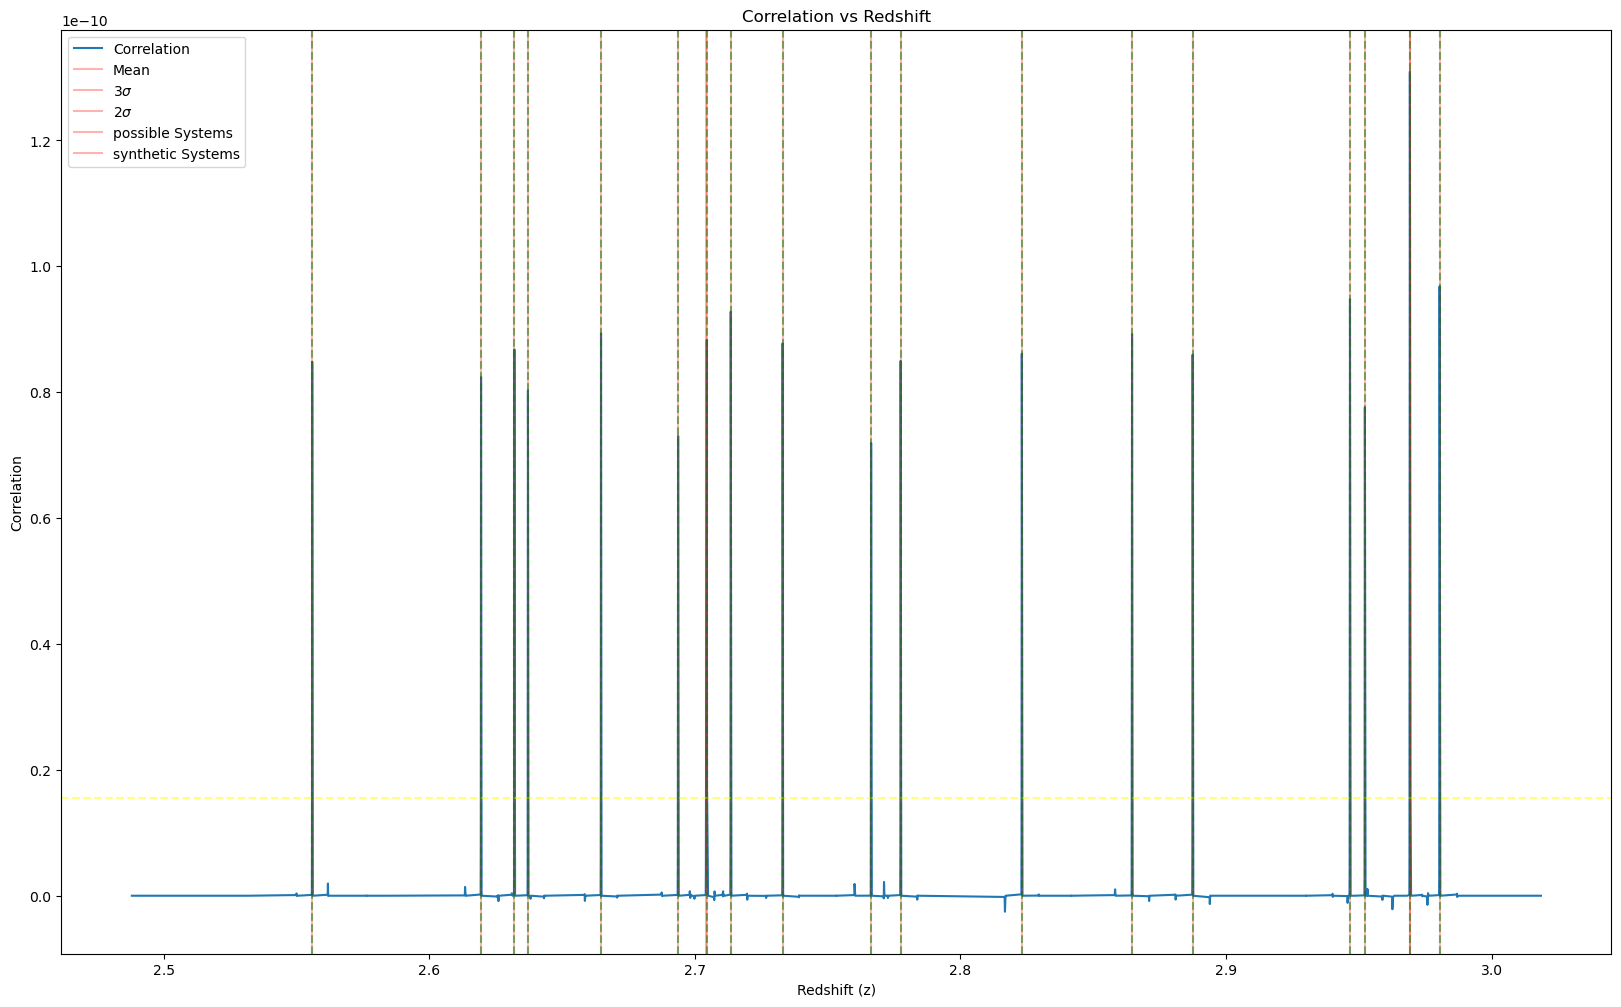

In [165]:
plot_correlation(cor_final, np.arange(z_start, z_end, dz), peaks, synthetic_systems)
